# Plot grapfico 

In [5]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from evaluate import load

In [ ]:
!pip install rouge_score

In [4]:
bleu = load("bleu")
rouge = load("rouge")
meteor = load("meteor")

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/emilioleo/nltk_data...
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/emilioleo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/emilioleo/nltk_data...


In [38]:
def compute_metrics_model(name_model,predictions,references):
    #results
    results = { "model": "", "BLEU": 0.0,"ROUGE":0.0,"METEOR":0.0}
    results["model"]=name_model
    # ---Bleu metrics---
    bleu_scores = [bleu.compute(predictions=[p], references=[r])["bleu"] for p, r in zip(predictions, references)]
    results["BLEU"]=sum(bleu_scores)/len(bleu_scores)
    
    #---Rouge-L metrics---
    rouge_scores = [rouge.compute(predictions=[p], references=[r])["rougeL"] for p, r in zip(predictions, references)]
    results["ROUGE"]=sum(rouge_scores)/len(rouge_scores)
    
    #---Meteor metrics ---
    meteor_scores = [meteor.compute(predictions=[p], references=[r])["meteor"] for p, r in zip(predictions, references)]
    results["METEOR"]=sum(meteor_scores)/len(meteor_scores)

    return results

In [ ]:
models={"mistral":(df_mistral["Sentence"],df_mistral["generated_translation"]),"NLLB": (df_nllb["Sentence"],df_nllb["generated_translation"]),"mt5":(df_mt5["Sentence"],df_mt5["generated_translation"]),"tinyllama":(df_tinyllama["Sentence"],df_tinyllama["generated_translation"])}


list_dict=[]
for m in models:
    dict_metric=compute_metrics_model(m,models[m][1],models[m][0])
    print(f"Dict metric model {m}: {dict_metric}")
    list_dict.append(dict_metric)

df_metrics=pd.DataFrame([list_dict[0],list_dict[1],list_dict[2],list_dict[3]])
df_metrics.head(5)

Dict metric model mistral: {'model': 'mistral', 'BLEU': 0.12779102719465088, 'ROUGE': np.float64(0.453937219841177), 'METEOR': np.float64(0.44859095547309635)}
Dict metric model NLLB: {'model': 'NLLB', 'BLEU': 0.1367869588545511, 'ROUGE': np.float64(0.4919907197290351), 'METEOR': np.float64(0.4709977051247547)}
Dict metric model mt5: {'model': 'mt5', 'BLEU': 0.35207507626628093, 'ROUGE': np.float64(0.672118647960918), 'METEOR': np.float64(0.6561742173359684)}
Dict metric model tinyllama: {'model': 'tinyllama', 'BLEU': 0.24843164080614233, 'ROUGE': np.float64(0.44411981768955416), 'METEOR': np.float64(0.5091878158122438)}


,model,BLEU,ROUGE,METEOR
0,mistral,0.127791,0.453937,0.448591
1,NLLB,0.136787,0.491991,0.470998
2,mt5,0.352075,0.672119,0.656174
3,tinyllama,0.248432,0.444120,0.509188


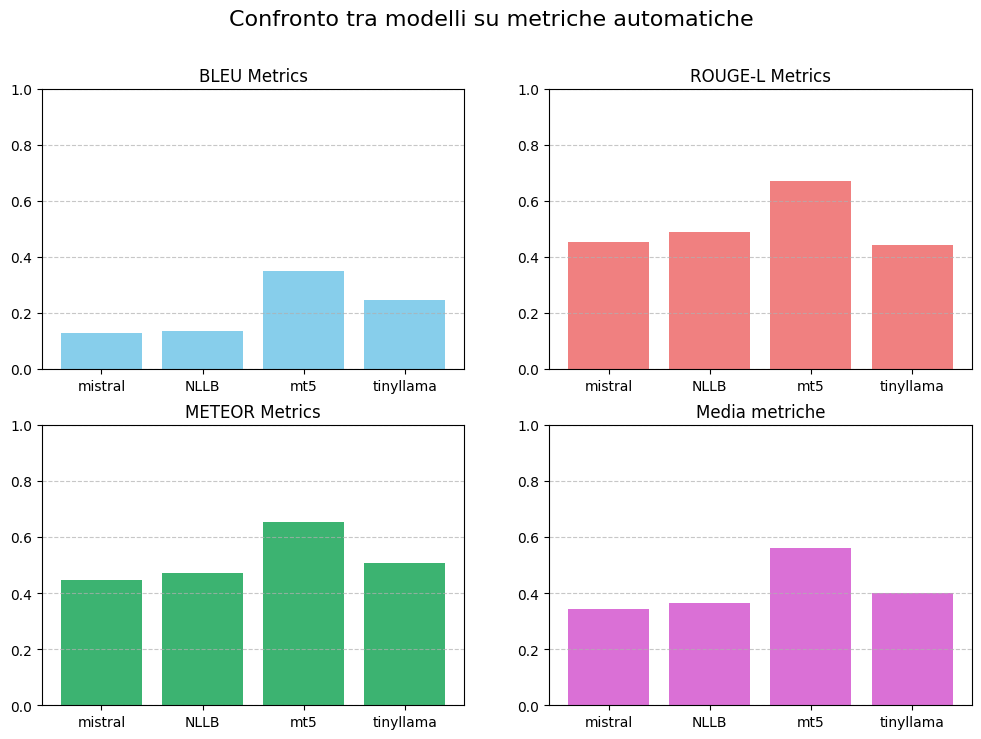

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Confronto tra modelli su metriche automatiche", fontsize=16)

axes[0, 0].bar(df_metrics["model"],df_metrics["BLEU"], color='skyblue')
axes[0, 0].set_title("BLEU Metrics")
axes[0, 0].set_ylim(0, 1)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

axes[0, 1].bar(df_metrics["model"],df_metrics["ROUGE"], color='lightcoral')
axes[0, 1].set_title("ROUGE-L Metrics")
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

axes[1, 0].bar(df_metrics["model"],df_metrics["METEOR"], color='mediumseagreen')
axes[1, 0].set_title("METEOR Metrics")
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

average_score=[]
for b, r, m in zip(df_metrics["BLEU"],df_metrics["ROUGE"],df_metrics["METEOR"]):
    average_score.append((b + r + m) / 3)

    
axes[1, 1].bar(df_metrics["model"], average_score, color='orchid')
axes[1, 1].set_title("Media metriche")
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
